In [11]:
import pandas as pd
import numpy as np
import limix
from load_genotypes import load_genotypes_plink
from generate_kinship import generate_kinship
from matplotlib.pyplot import *
%matplotlib inline

covariates_filename = '../data/geuvadis_CEU_YRI_test_data/Geuvadis_CEU_YRI_covariates.txt'
geno_prefix = '../data/geuvadis_CEU_YRI_test_data/Geuvadis_chr1'
pheno_filename = '../data/geuvadis_CEU_YRI_test_data/Geuvadis_CEU_YRI_Expr.txt'
anno_filename = '../data/geuvadis_CEU_YRI_test_data/Geuvadis_CEU_YRI_Annot.txt'

covariate_df = pd.read_csv(covariates_filename,sep='\t',index_col=0)

kinship_df = pd.read_csv('../data/geuvadis_CEU_YRI_test_data/Geuvadis_chr1_kinship.txt',sep='\t',index_col=0)

bim,fam,bed = limix.io.read_plink(geno_prefix)
fam.set_index('iid',inplace=True)

phenotype_df = pd.read_csv(pheno_filename,sep='\t',index_col=0)
annotation_df = pd.read_csv(anno_filename,sep='\t',index_col=1)
individual2sample_df = pd.read_csv('../data/geuvadis_CEU_YRI_test_data/Geuvadis_CEU_gte.txt',sep='\t',header=None,names=['ID','Sample'],index_col=0)

Reading ../data/geuvadis_CEU_YRI_test_data/Geuvadis_chr1.bim... done (0.01 s)
Reading ../data/geuvadis_CEU_YRI_test_data/Geuvadis_chr1.fam... done (0.00 s)
Reading ../data/geuvadis_CEU_YRI_test_data/Geuvadis_chr1.bed... done (0.00 s)


In [18]:
qtl_results_df = pd.DataFrame(columns=['feature_id','snp_id','p_value','beta'])

ws = 250000
feature_list = list(set(annotation_df.index)&set(phenotype_df.index))

for feature_id in feature_list:
    
    chrom = str(annotation_df.loc[feature_id,'Chromosome Name'])
    start = annotation_df.loc[feature_id,'Gene Start (bp)']
    end = annotation_df.loc[feature_id,'Gene End (bp)']
    center_pos = start + (start-end)/2
    cis = bim.query("chrom == '%s' & pos > %d & pos < %d" % (chrom, center_pos-ws, center_pos+ws))
    snp_idxs = cis['i'].values
    snp_names = cis['snp'].values

    #make sure to only look up the non NA valued samples for this feature.
    
    #indices for relevant individuals in genotype matrix
    individual_ids = list(set(fam.index)&set(individual2sample_df.index))
    individual_idxs = fam.loc[individual_ids,'i'].values

    #subset genotype matrix and kinship matrix
    snps = bed[snp_idxs,:].compute().transpose()
    if len(snps) == 0:
        continue
    snps = snps[individual_idxs,:]
    
    kinship_mat = kinship_df.loc[individual_ids,individual_ids].as_matrix()

    #map individual_ids to samples
    sample_ids = individual2sample_df.loc[individual_ids,'Sample'].values
    phenotype = phenotype_df.loc[feature_id,sample_ids].as_matrix()
    
    
    #generate covariate matrix
    cov_matrix = np.concatenate([np.ones((len(sample_ids),1)),covariate_df.loc[sample_ids,:].as_matrix()],axis=1)
    
    #fit model
    LMM = limix.qtl.qtl_test_lmm(snps, phenotype,K=kinship_mat)
    
    #add these results to qtl_results

    temp_df = pd.DataFrame(index = range(len(snp_names)),columns=['feature_id','snp_id','p_value','beta'])
    temp_df['snp_id'] = snp_names
    temp_df['feature_id'] = feature_id
    temp_df['beta'] = LMM.getBetaSNP()[0]
    temp_df['p_value'] = LMM.getPv()[0]
    qtl_results_df = qtl_results_df.append(temp_df, ignore_index=True)

In [20]:
qtl_results_df[qtl_results_df['p_value']<1e-14]

,feature_id,snp_id,p_value,beta
1875,ENSG00000049247,snp_1_7960311,3.117172e-37,-5.648187
13158,ENSG00000189339,snp_1_1590681,6.516004e-18,-0.439467
13159,ENSG00000189339,snp_1_1602536,1.094289e-17,-0.443429
15738,ENSG00000226969,snp_1_1925338,1.183960e-18,-1.351371


In [13]:
qtl_results_df.set_index(['feature_id','snp_id'],inplace=True)

In [14]:
molgenis_results_df = pd.read_csv('../data/geuvadis_CEU_YRI_test_data/TestOutput/Cis-CEU-eQTLsFDR0.05.txt',sep='\t')
molgenis_results_df['beta'] = molgenis_results_df['Beta (SE)'].map(lambda x: float(x.split()[0]))
molgenis_results_df['p_value'] = molgenis_results_df['PValue']
molgenis_results_df.set_index(['ProbeName','SNPName'],inplace=True)

In [15]:
index = molgenis_results_df.index


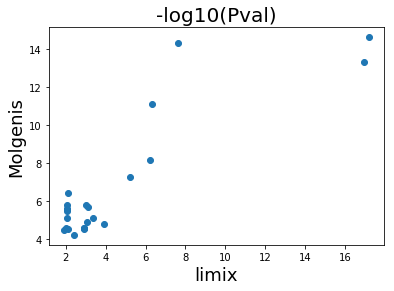

In [16]:
index = list(set(molgenis_results_df.index) & set(qtl_results_df.index))

plot(-np.log10(qtl_results_df.loc[index,'p_value']),-np.log10(molgenis_results_df.loc[index,'p_value']),'o')

FS = 18
title('-log10(Pval)',fontsize=FS+2)
xlabel('limix',fontsize=FS)
ylabel('Molgenis',fontsize=FS)

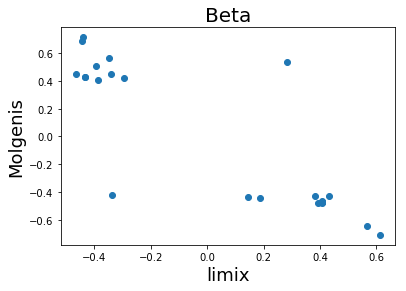

In [17]:
plot(qtl_results_df.loc[index,'beta'],molgenis_results_df.loc[index,'beta'],'o')

FS = 18
title('Beta',fontsize=FS+2)
xlabel('limix',fontsize=FS)
ylabel('Molgenis',fontsize=FS)